## **70028 - Reinforcement Learning: Coursework 2**
### Belfiore Asia, cid: 02129867
---

In [50]:
from importlib import reload
import utils
reload(utils)
from utils import train_net, visualise_net_results, print_hyperparameters, plot_return_by_episode
import torch

In [49]:
model_number = 49
# model_number -= 1
model_number

49

Starting run 1 of 10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


  Episode  100 / 300
  Average duration:  82.71
  Episode  200 / 300
  Average duration:  204.84
  Episode  300 / 300
  Average duration:  148.58
Starting run 2 of 10
  Episode  100 / 300
  Average duration:  123.61
  Episode  200 / 300
  Average duration:  115.02
  Episode  300 / 300
  Average duration:  328.68
Starting run 3 of 10
  Episode  100 / 300
  Average duration:  140.61
  Episode  200 / 300
  Average duration:  452.85
  Episode  300 / 300
  Average duration:  309.36
Starting run 4 of 10
  Episode  100 / 300
  Average duration:  35.55
  Episode  200 / 300
  Average duration:  166.86
  Episode  300 / 300
  Average duration:  476.9
Starting run 5 of 10
  Episode  100 / 300
  Average duration:  45.98
  Episode  200 / 300
  Average duration:  173.93
  Episode  300 / 300
  Average duration:  306.29
Starting run 6 of 10
  Episode  100 / 300
  Average duration:  16.36
  Episode  200 / 300
  Average duration:  226.27
  Episode  300 / 300
  Average duration:  422.84
Starting run 7 of 

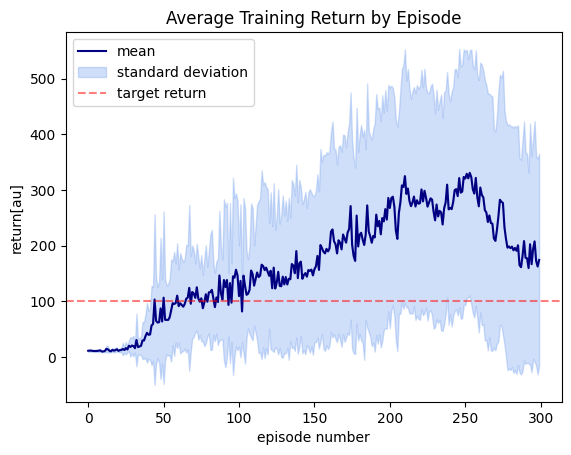

Saved figure at results/Q1/Adam/49-return.png
Printing policy


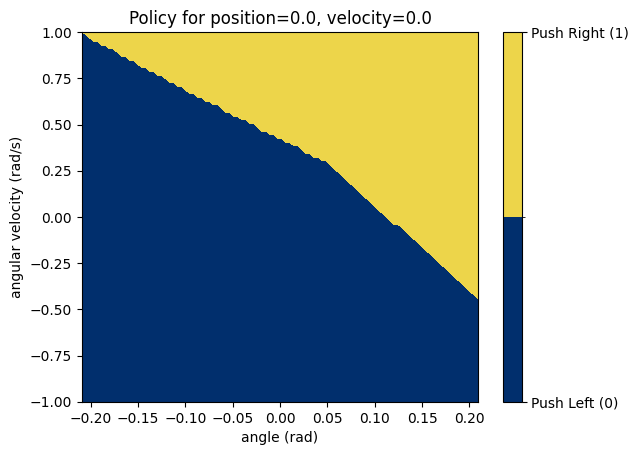

Saved figure at results/Q2/49/0.png


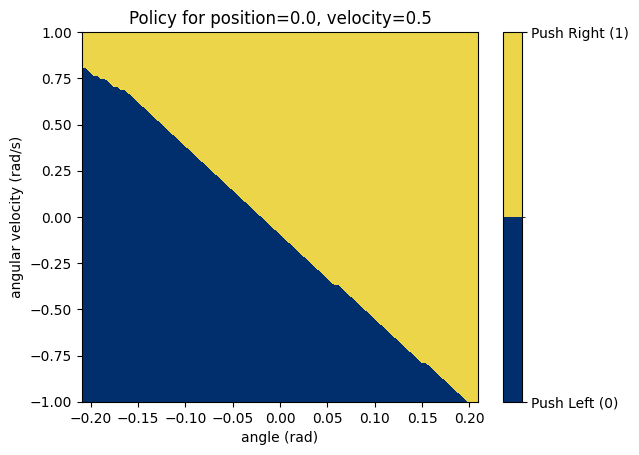

Saved figure at results/Q2/49/05.png


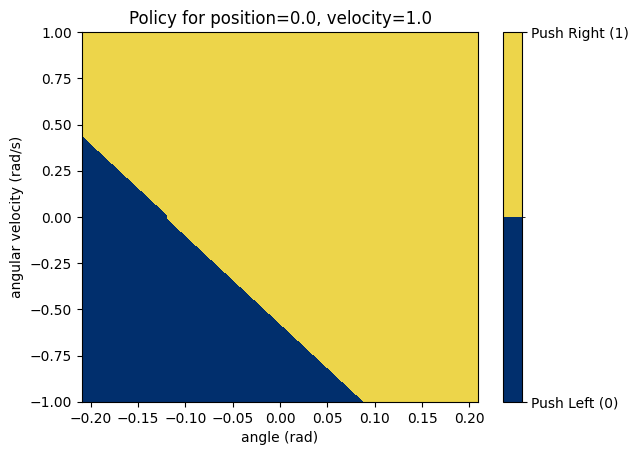

Saved figure at results/Q2/49/1.png


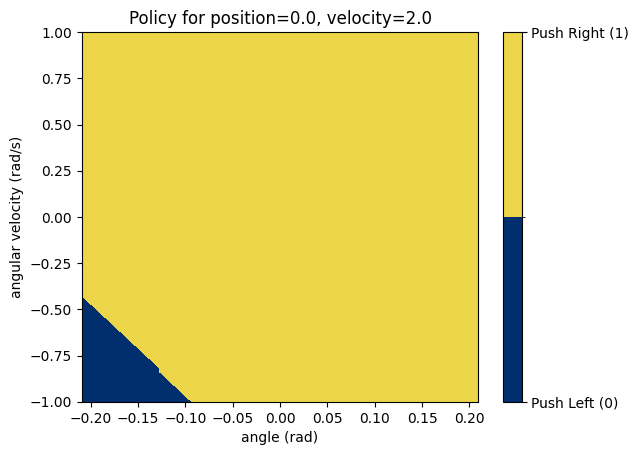

Saved figure at results/Q2/49/2.png
Printing Q values


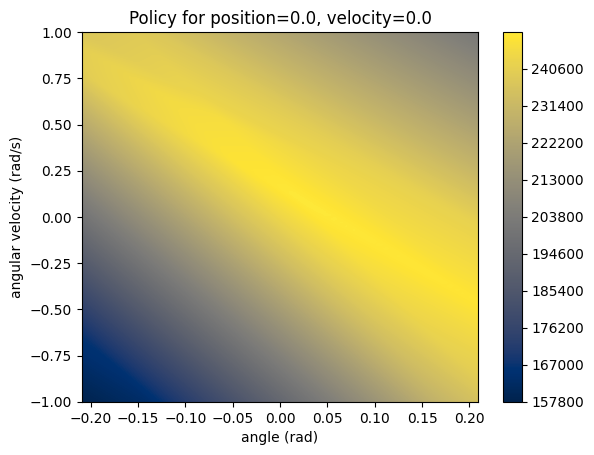

Saved figure at results/Q2/49/q-0.png


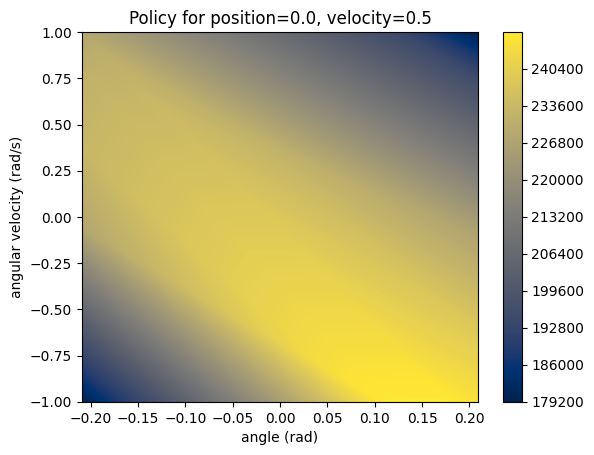

Saved figure at results/Q2/49/q-05.png


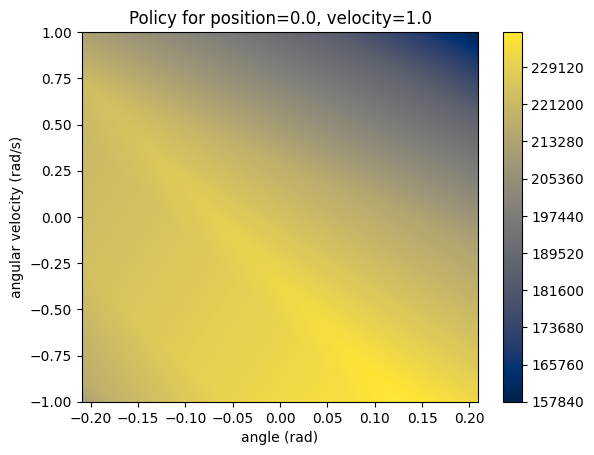

Saved figure at results/Q2/49/q-1.png


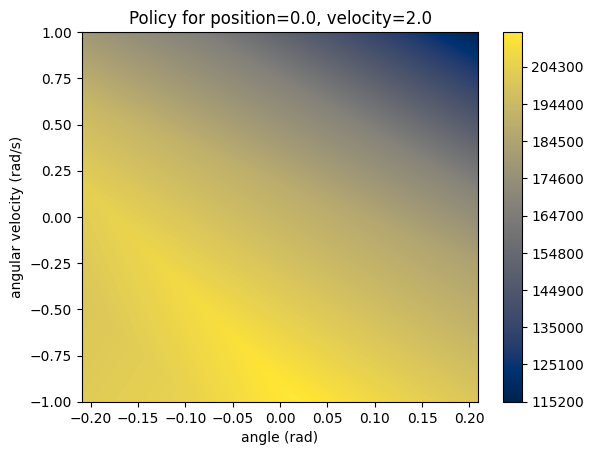

Saved figure at results/Q2/49/q-2.png


<Figure size 640x480 with 0 Axes>

In [51]:
# Keep track of the model version
# model_number = 1
save_model = [True, "model/policy_net.pth"]
save_fig = True

# Set hyperparameters
NUM_RUNS = 10 # [OK]

A = 5 # [OK] size of each hidden layer
B = 2 # [OK] number of DQN hidden layers
C = 0.01 # [OK] learning rate
D = 60000 # [OK] size of Replay Buffer
E = 300 # [OK] number of training episodes (needs to stabilise for >50)
F = 0.2 # [OK] epsilon value for epsilon-greedy policy
G = 1 # [OK] reward discount
H = 100 # size of replay sampled training batch
I = 50 # frequency (number of steps) of target network update

# Additional parameters
DECAY_RATE = 0.995 # [OK] epsilon decay rate
model_optim="Adam" # [OK] model optimizer

# Q1
# Train Model
runs_results = train_net(NUM_RUNS, A, B, C, D, E, F, G, H, I, decay=DECAY_RATE, model_optim=model_optim, save=save_model, show=False)
# Plot the learning curve (mean and standard deviation of return 
# throughout training over NUM_RUNS many runs)
print_hyperparameters(A, B, C, D, E, F, G, H, I, DECAY_RATE)
plot_return_by_episode(runs_results, save=[save_fig, "Adam", model_number])

# Q2
# Visualise Greedy Policy and Q-values for the cart according to the "policy_net" network
# as a 2D plot function of pole angle and angular velocity.
net = torch.load(save_model[1], weights_only=False) # load DQN
net.eval()

# Fix the cart position to the centre of the track (position=0) 
# and test cart velocities of 0., 0.5, 1. and 2.
velocities = [0., 0.5, 1., 2.]

for q in [False, True]:  # whether q values or greedy policy is visualised
    if q: print("Printing Q values")
    else: print("Printing policy")
    for velocity in velocities:
        visualise_net_results(net=net, position=0., velocity=velocity, q=q, save=[save_fig, model_number])

model_number += 1